Steane code fault tolerant ancilla
===========================

1. Set up logical zero for Steane code based on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up fault tolerant ancilla as also described in Nielsen and Chuang.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from circuits import SteaneCodeLogicalQubit

from helper_functions import (
    get_noise,
    get_parity_check_matrix,
    get_codewords
)
    

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_ERRORS = ['x', 'y', 'z', 'h', 's', 'sdg']
TWO_GATE_ERRORS = ['cx', 'cz']

TESTING = False                          #Test by applying and X or Z error to one of the qubits
TEST_X_QUBIT = 2                         #Qbit to set bit flip- Starts at zero.
TEST_X_LOGICAL = 0                       #logical Qbit to set bit flip- Starts at zero.
TEST_Z_QUBIT = 0                         #Qbit to phase flip- Starts at zero.
TEST_Z_LOGICAL = 0                       #logical Qbit to set phase flip- Starts at zero.

NOISE = False                            #Test with noise
SHOTS = 1000                             #Number of shots to run    
MEASURE_NOISE = 0.0046                   #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366      #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022
FACTOR = 1

SIMULATOR = Aer.get_backend('qasm_simulator')

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


Create an instance of the logical qubits needed.  The parity check matrix above as an input.

The number of qubits needed is an argument to the class and should be 1 or 2 at present.

In [5]:
qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, fault_tolerant_ancilla = True, ancilla_rounds = 3)

Use a method to initialise the logical qubits as a logical zero as required.

In [6]:
qubit.set_up_logical_zero(0)

If TESTING is active we test the ancilla with an X and Z error and check that the correct error syndrome is returned.

In [7]:
if TESTING:
    qubit.force_X_error(TEST_X_QUBIT, TEST_X_LOGICAL)   #force X error for testing
    #qubit.force_Z_error(TEST_Z_QUBIT,TEST_Z_LOGICAL)   #force Z error for testing
    qubit.barrier()

In [8]:
if NOISE:
    noise_model = get_noise(MEASURE_NOISE * FACTOR, SINGLE_GATE_DEPOLARISING * FACTOR, 
                            TWO_GATE_DEPOLARISING * FACTOR, SINGLE_GATE_ERRORS, 
                            TWO_GATE_ERRORS )

Set up ancilla and make a logical measurement three times

In [9]:
for i in range(3):
    qubit.set_up_ancilla(0)
    j = 3 - i 
    qubit.logical_measure_ancilla(0, j)

Measure data

In [10]:
qubit.logical_measure_data(0)

In [11]:
#Measurement noise
if NOISE:
    result = execute(qubit, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
else:
    result = execute(qubit, SIMULATOR, shots=SHOTS).result()

Execute results and print out. 

In [12]:
counts = result.get_counts(qubit)
print ('The different states can be counted.  The simulated result are', counts)

The different states can be counted.  The simulated result are {'0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000000': 134, '0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0011110': 116, '0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0101101': 132, '0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0110011': 123, '0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 1001011': 118, '0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 1010101': 123, '0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 1100110': 121, '0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 1111000': 133}


Print out circuit:

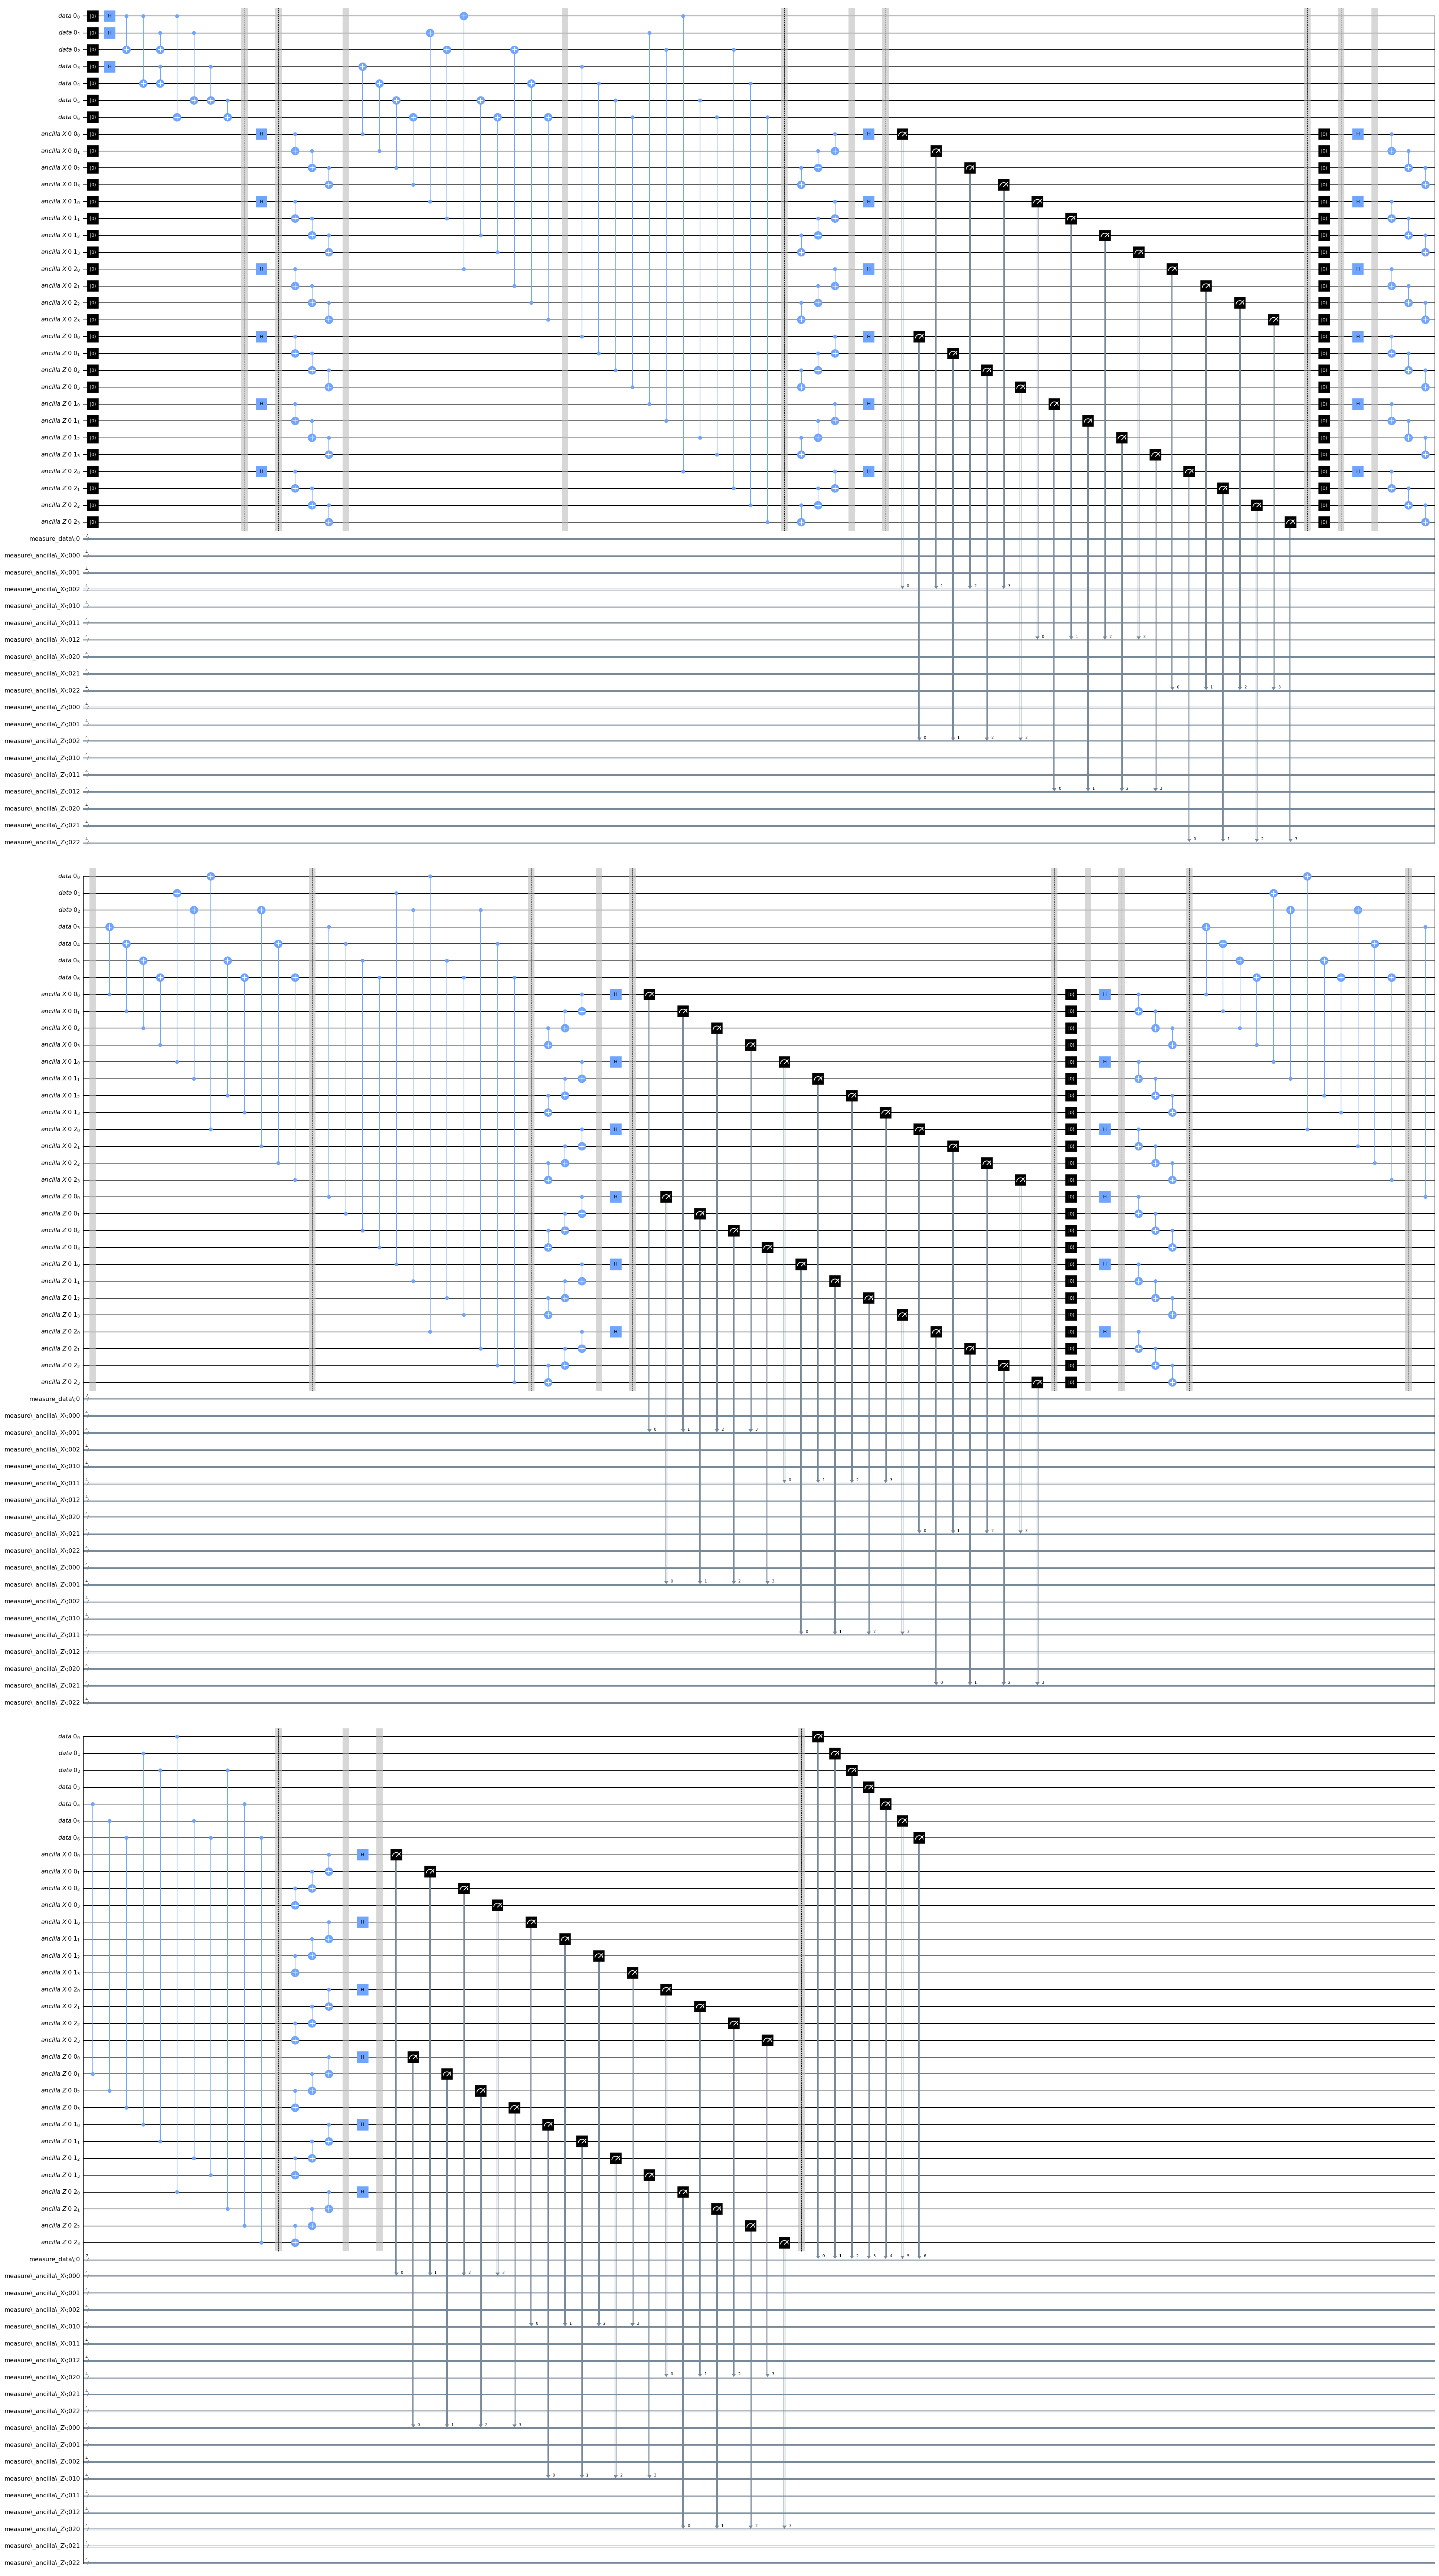

In [13]:
qubit.draw(output='mpl', filename = './circuits/Steane_code_FT_ancilla_circuit.jpg', fold = 80)